#installing dependencies

In [1]:
# MUST BE ON T4 GPU

import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Sat Apr 20 09:50:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-------

This notebook works fine with transformers 4.12, it is not tested on newer versions

In [2]:
! pip install -U accelerate
!pip install transformers==4.30
!pip install farasapy==0.0.14
!pip install pyarabic==0.6.14
!git clone https://github.com/aub-mind/arabert
!pip install emoji==1.6.1
!pip install sentencepiece==0.1.96

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 1.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

Let's download some Arabic text classification datasets

In [3]:
!git clone https://github.com/elnagara/HARD-Arabic-Dataset
!git clone https://github.com/mahmoudnabil/ASTD
!git clone https://github.com/nora-twairesh/AraSenti
!git clone https://github.com/mohamedadaly/LABR
!wget http://homepages.inf.ed.ac.uk/wmagdy/Resources/ArSAS.zip
!unzip ArSAS.zip
!unrar x '/content/HARD-Arabic-Dataset/data/unbalanced-reviews.rar'
!unzip '/content/HARD-Arabic-Dataset/data/balanced-reviews.zip'

Cloning into 'HARD-Arabic-Dataset'...
remote: Enumerating objects: 100, done.
remote: Total 100 (delta 0), reused 0 (delta 0), pack-reused 100
Receiving objects: 100% (100/100), 116.36 MiB | 40.21 MiB/s, done.
Resolving deltas: 100% (35/35), done.
Cloning into 'ASTD'...
remote: Enumerating objects: 29, done.
remote: Total 29 (delta 0), reused 0 (delta 0), pack-reused 29
Receiving objects: 100% (29/29), 558.04 KiB | 4.20 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Cloning into 'AraSenti'...
remote: Enumerating objects: 20, done.
remote: Total 20 (delta 0), reused 0 (delta 0), pack-reused 20
Receiving objects: 100% (20/20), 1.69 MiB | 8.54 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Cloning into 'LABR'...
remote: Enumerating objects: 37, done.
remote: Total 37 (delta 0), reused 0 (delta 0), pack-reused 37
Receiving objects: 100% (37/37), 12.32 MiB | 18.00 MiB/s, done.
Resolving deltas: 100% (12/12), done.
--2024-04-20 09:53:08--  http://homepages.inf.ed.ac.uk/wmagdy/Resources/A

#Creating training datasets

In [4]:
import pandas as pd
import numpy as np
from typing import List
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

This custom dataset class will help us hold our datasets in a structred manner.
It's not necessary to use it with your own data

In [5]:
class CustomDataset:
    def __init__(
        self,
        name: str,
        train: List[pd.DataFrame],
        test: List[pd.DataFrame],
        label_list: List[str],
    ):
        """Class to hold and structure datasets.

        Args:

        name (str): holds the name of the dataset so we can select it later
        train (List[pd.DataFrame]): holds training pandas dataframe with 2 columns ["text","label"]
        test (List[pd.DataFrame]): holds testing pandas dataframe with 2 columns ["text","label"]
        label_list (List[str]): holds the list  of labels
        """
        self.name = name
        self.train = train
        self.test = test
        self.label_list = label_list

In [6]:
# This will hold all the downloaded and structred datasets
all_datasets= []
DATA_COLUMN = "text"
LABEL_COLUMN = "label"

You can choose which ever dataset you like or use your own.
At this stage we don't do any preprocessing on the text, this is done later when loading the text.

##HARD - Balanced

In [7]:
df_HARD = pd.read_csv("/content/balanced-reviews.txt", sep="\t", header=0,encoding='utf-16')

df_HARD = df_HARD[["review","rating"]]  # we are interested in rating and review only
df_HARD.columns = [DATA_COLUMN, LABEL_COLUMN]
print(df_HARD[LABEL_COLUMN].value_counts())
# code rating as +ve if > 3, -ve if less, no 3s in dataset

hard_map = {
    5: 'POS',
    4: 'POS',
    2: 'NEG',
    1: 'NEG'
}

df_HARD[LABEL_COLUMN] = df_HARD[LABEL_COLUMN].apply(lambda x: hard_map[x])
train_HARD, test_HARD = train_test_split(df_HARD, test_size=0.2, random_state=42)
label_list_HARD = ['NEG', 'POS']

data_Hard = CustomDataset("HARD", train_HARD, test_HARD, label_list_HARD)
all_datasets.append(data_Hard)

label
2    38467
4    26450
5    26399
1    14382
Name: count, dtype: int64


##ASTD- Unbalanced

In [8]:
df_ASTD_UN = pd.read_csv(
    "/content/ASTD/data/Tweets.txt", sep="\t", header=None
)

df_ASTD_UN.columns = [DATA_COLUMN, LABEL_COLUMN]

df_ASTD_UN = df_ASTD_UN[df_ASTD_UN[LABEL_COLUMN]!= 'OBJ']

train_ASTD_UN, test_ASTD_UN = train_test_split(
    df_ASTD_UN, test_size=0.2, random_state=42
)

label_list_ASTD_UN = list(df_ASTD_UN[LABEL_COLUMN].unique())
print(label_list_ASTD_UN)
print(df_ASTD_UN[LABEL_COLUMN].value_counts())

data_ASTD_UN = CustomDataset(
    "ASTD-Unbalanced", train_ASTD_UN, test_ASTD_UN, label_list_ASTD_UN
)

all_datasets.append(data_ASTD_UN)

['POS', 'NEG', 'NEUTRAL']
label
NEG        1642
NEUTRAL     805
POS         777
Name: count, dtype: int64


In [9]:
for x in all_datasets:
  print(x.name)

HARD
ASTD-Unbalanced


#Trainer

Start the training procedure

In [10]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import copy

from arabert.preprocess import ArabertPreprocessor
from sklearn.metrics import (accuracy_score, classification_report,
                            confusion_matrix, f1_score, precision_score,
                             recall_score)
from torch.utils.data import DataLoader, Dataset
from transformers import (AutoConfig, AutoModelForSequenceClassification,
                          AutoTokenizer, BertTokenizer, Trainer,
                          TrainingArguments)
from transformers.data.processors.utils import InputFeatures

List all the datasets we have

In [11]:
for x in all_datasets:
  print(x.name)

HARD
ASTD-Unbalanced


In [12]:
# select a dataset
dataset_name = 'ASTD-Unbalanced'
# select a model from the huggingface modelhub https://huggingface.co/models?language=ar
model_name = 'aubmindlab/bert-base-arabertv02-twitter' # we are going to use the twitter AraBERT since it has emojis and dialects

In [13]:
for d in all_datasets:
  if d.name==dataset_name:
    selected_dataset = copy.deepcopy(d)
    print('Dataset found')
    break

Dataset found


Create and apply preprocessing using the AraBERT processor

In [14]:
arabic_prep = ArabertPreprocessor(model_name)

selected_dataset.train[DATA_COLUMN] = selected_dataset.train[DATA_COLUMN].apply(lambda x: arabic_prep.preprocess(x))
selected_dataset.test[DATA_COLUMN] = selected_dataset.test[DATA_COLUMN].apply(lambda x: arabic_prep.preprocess(x))

In [15]:
# Sanity check on the dataset
list(selected_dataset.train[DATA_COLUMN][0:10])

['لم تعد مصر تحتمل تكرر دوائر العنف والعنف المضاد ، ولم تعد أيضا تحتمل التهاوي المرعب في قدرات الدولة',
 'مهما حاولتم إقناع أنفسكم أن الشعب إختار دستور الإخوان دون تخويف أو لعب بالدين أو إنتهاكات ستظل الحقيقة أن مرسي كذب على المصريين ليمرر دستوره',
 'دور رائع ومفاجئ لنساء مصر فى المظاهرات شبابنا ونساءنا يستحقون الصدارة ان شاء الله بعد سقوط الانقلاب',
 '5 هاتلي اخوان أي حاجة مش تنوين ومش ضمير اخوان وبعدها كلمة مش هتلاقي غير لوط وشياطين !',
 'دباسم يوسف عمل برنامج البرنامج و # فسس',
 'منذ عامين وحتى الآن كل ما قدمه أنصار تيارات الشعارات الإسلامية لمصر مجرد مشاريع خناقات مع العالم والكون وأبناء الوطن',
 '# السعاده ان يكون من نحب بخير وعافيه فنحن نشعر بهم ونهتم لامرهم حتى لو لم نراهم 3 "',
 'درية شرف الدين امرأة على الوشين لا مهنية ولا اخلاق ولا وطنية ولا حياء الملايين ملأوا شوارع مصر وشاشاتها تنقل ميادين اخلاها الجيش للتصوير',
 ', جيرارد ماذا فعلت ! ! هل تهدم ما فعله # ليفربول 😥 لو جآت من غير ترا كآن هآنت أما تجي من يآآهي قو …',
 '3 تم الإتصال أكثر من مرة وستكون عندنا بالغد في لجنة حقوق ا

Now we need to check the tokenized sentence length to decide on the maximum sentence length value

In [16]:
tok = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/476 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/751k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Training Sentence Lengths: 


Token indices sequence length is longer than the specified maximum sequence length for this model (610 > 512). Running this sequence through the model will result in indexing errors


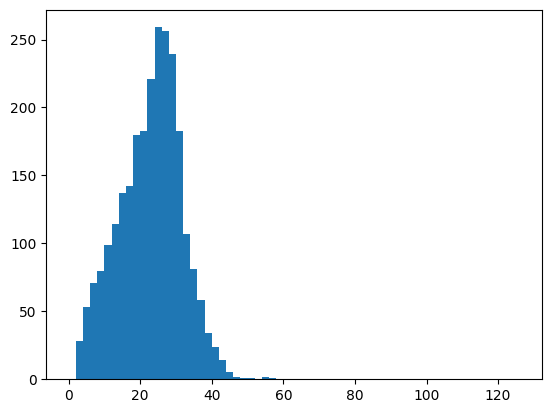

Testing Sentence Lengths: 


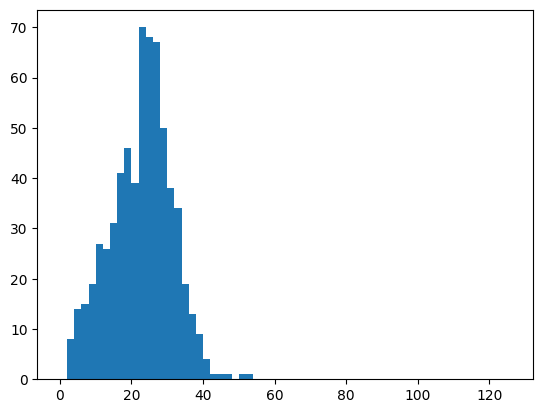

In [17]:
print("Training Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in selected_dataset.train[DATA_COLUMN].to_list()],bins=range(0,128,2))
plt.show()

print("Testing Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in selected_dataset.test[DATA_COLUMN].to_list()],bins=range(0,128,2))
plt.show()

Let's select 100 as our maximum sentence length, and check how many sequences will be truncated

In [18]:
max_len = 60

In [19]:
print("Truncated training sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in selected_dataset.test[DATA_COLUMN].to_list()]))

print("Truncated testing sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in selected_dataset.test[DATA_COLUMN].to_list()]))

Truncated training sequences:  2
Truncated testing sequences:  2


Now let's create a classification dataset to load the data

In [20]:
class ClassificationDataset(Dataset):
    def __init__(self, text, target, model_name, max_len, label_map):
      super(ClassificationDataset).__init__()
      """
      Args:
      text (List[str]): List of the training text
      target (List[str]): List of the training labels
      tokenizer_name (str): The tokenizer name (same as model_name).
      max_len (int): Maximum sentence length
      label_map (Dict[str,int]): A dictionary that maps the class labels to integer
      """
      self.text = text
      self.target = target
      self.tokenizer_name = model_name
      self.tokenizer = AutoTokenizer.from_pretrained(model_name)
      self.max_len = max_len
      self.label_map = label_map


    def __len__(self):
      return len(self.text)

    def __getitem__(self,item):
      text = str(self.text[item])
      text = " ".join(text.split())

      inputs = self.tokenizer(
          text,
          max_length=self.max_len,
          padding='max_length',
          truncation=True
      )
      return InputFeatures(**inputs,label=self.label_map[self.target[item]])

In [21]:
label_map = { v:index for index, v in enumerate(selected_dataset.label_list) }
print(label_map)

train_dataset = ClassificationDataset(
    selected_dataset.train[DATA_COLUMN].to_list(),
    selected_dataset.train[LABEL_COLUMN].to_list(),
    model_name,
    max_len,
    label_map
  )
test_dataset = ClassificationDataset(
    selected_dataset.test[DATA_COLUMN].to_list(),
    selected_dataset.test[LABEL_COLUMN].to_list(),
    model_name,
    max_len,
    label_map
  )

{'POS': 0, 'NEG': 1, 'NEUTRAL': 2}


Check the dataset output

In [22]:
print(next(iter(train_dataset)))

InputFeatures(input_ids=[2, 407, 1625, 786, 25704, 21797, 12864, 3102, 15417, 24888, 103, 1174, 1625, 1076, 25704, 19881, 408, 59304, 305, 8561, 975, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], label=1)


Create a function that return a pretrained model ready to do classification

In [23]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True, num_labels=len(label_map))

Define whatever metric you want here

In [24]:
def compute_metrics(p): #p should be of type EvalPrediction
  preds = np.argmax(p.predictions, axis=1)
  assert len(preds) == len(p.label_ids)
  #print(classification_report(p.label_ids,preds))
  #print(confusion_matrix(p.label_ids,preds))
  macro_f1 = f1_score(p.label_ids,preds,average='macro')
  #macro_precision = precision_score(p.label_ids,preds,average='macro')
  #macro_recall = recall_score(p.label_ids,preds,average='macro')
  acc = accuracy_score(p.label_ids,preds)
  return {
      'macro_f1' : macro_f1,
      'accuracy': acc
  }

In [25]:
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic=True
  torch.backends.cudnn.benchmark = False

#Regular Training

Define our training parameters.
Check the TrainingArguments documentation for more options https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments

In [26]:
training_args = TrainingArguments(
    output_dir= "./train",
    adam_epsilon = 1e-8,
    learning_rate = 2e-5,
    fp16 = True, # enable this when using V100 or T4 GPU
    per_device_train_batch_size = 16, # up to 64 on 16GB with max len of 128
    per_device_eval_batch_size = 128,
    gradient_accumulation_steps = 2, # use this to scale batch size without needing more memory
    num_train_epochs= 6,
    warmup_ratio = 0,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True, # this allows to automatically get the best model at the end based on whatever metric we want
    metric_for_best_model = 'macro_f1',
    greater_is_better = True,
    seed = 25
  )

set_seed(training_args.seed)

In [27]:
trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

config.json:   0%|          | 0.00/667 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02-twitter were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02-twitter and are newly initialized: ['be

In [28]:
#start the training
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
1,No log,0.657357,0.655397,0.727132
2,No log,0.615506,0.703550,0.747287
3,No log,0.631742,0.721498,0.748837
4,No log,0.680764,0.711135,0.736434
5,No log,0.704659,0.721765,0.750388
6,No log,0.719167,0.720585,0.748837


TrainOutput(global_step=486, training_loss=0.4464959038628472, metrics={'train_runtime': 156.6996, 'train_samples_per_second': 98.749, 'train_steps_per_second': 3.101, 'total_flos': 477119182725360.0, 'train_loss': 0.4464959038628472, 'epoch': 6.0})

Save the model, the tokenizer and the config

In [29]:
inv_label_map = inv_label_map = { v:k for k, v in label_map.items()}
print(inv_label_map)
trainer.model.config.label2id = label_map
trainer.model.config.id2label = inv_label_map
trainer.save_model("output_dir")
train_dataset.tokenizer.save_pretrained("output_dir")

{0: 'POS', 1: 'NEG', 2: 'NEUTRAL'}


('output_dir/tokenizer_config.json',
 'output_dir/special_tokens_map.json',
 'output_dir/vocab.txt',
 'output_dir/added_tokens.json',
 'output_dir/tokenizer.json')

In [30]:
print(label_map)

{'POS': 0, 'NEG': 1, 'NEUTRAL': 2}


In [31]:
#copy the model to drive
!cp ./output_dir /content/drive/MyDrive

cp: -r not specified; omitting directory './output_dir'


## predict using the saved model

In [32]:
from transformers import pipeline

In [33]:
# initialize pipline
pipe = pipeline("sentiment-analysis", model="output_dir", device=0, return_all_scores=False)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [34]:
pipe("انا سعيد")

[{'label': 'POS', 'score': 0.9599370956420898}]

In [35]:
%pip install camel-tools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.3/124.3 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.6/426.6 kB 6.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for camel-kenlm: filename=camel_kenlm-2023.3.17.2-cp310-cp310-linux_x86_64.whl size=3453123 sha256=bb149b4d3ba8423152e20458762b4d72eaac670912f7fb107fb34e3b85015562
  Stored in directory: /root/.cache/pip/wheels/29/c5/32/09633c3b70fdfc470b2fb912bd9e90d8d6814df68c794dcaa6
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=9ff9bcb8030013a8b55b220d24cc5f718bf612a4ce179217ccbe66c81910ec14
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4

In [36]:
from google.colab import drive
import os

drive.mount('/gdrive')

%mkdir /gdrive/MyDrive/camel_tools

Mounted at /gdrive


In [37]:
os.environ['CAMELTOOLS_DATA'] = '/gdrive/MyDrive/camel_tools'

!export | camel_data -i all

The following packages will be installed: 'morphology-db-msa-r13', 'morphology-db-glf-01', 'disambig-ranking-cache-calima-egy-r13', 'morphology-db-lev-01', 'sentiment-analysis-mbert', 'disambig-ranking-cache-calima-lev-01', 'dialectid-model6', 'disambig-mle-calima-msa-r13', 'disambig-ranking-cache-calima-glf-01', 'morphology-db-msa-s31', 'disambig-bert-unfactored-glf', 'dialectid-model26', 'disambig-ranking-cache-calima-msa-r13', 'disambig-bert-unfactored-egy', 'disambig-bert-unfactored-msa', 'disambig-bert-unfactored-lev', 'morphology-db-egy-r13', 'disambig-mle-calima-egy-r13', 'ner-arabert', 'sentiment-analysis-arabert'
Extracting package 'morphology-db-msa-r13': 100% 40.5M/40.5M [00:00<00:00, 119MB/s]
Extracting package 'morphology-db-glf-01': 100% 7.98M/7.98M [00:00<00:00, 160MB/s]
Extracting package 'disambig-ranking-cache-calima-egy-r13': 100% 320M/320M [00:06<00:00, 48.6MB/s]
Extracting package 'morphology-db-lev-01': 100% 10.6M/10.6M [00:00<00:00, 61.1MB/s]
Extracting package '

In [ ]:
%pip install camel-tools

from google.colab import drive
import os

drive.mount('/gdrive')
os.environ['CAMELTOOLS_DATA'] = '/gdrive/MyDrive/camel_tools'
Path = '/gdrive/MyDrive/Dataset'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [38]:
import pandas as pd
import re
from camel_tools.tokenizers.word import simple_word_tokenize
from camel_tools.utils.normalize import normalize_alef_maksura_ar
from camel_tools.utils.normalize import normalize_alef_ar
from camel_tools.utils.normalize import normalize_teh_marbuta_ar

In [39]:
def preprocess_tweet(tweet):
    # Removing usernames
    tweet = re.sub(r'@[^\s]+', '', tweet)

    # Removing links
    tweet = re.sub(r'(https?://\S+)|(www\.\S+)', '', tweet)

    # Removing emojis
    tweet = re.sub(r'[^\u0600-\u06FF\s]', '', tweet)  # Preserve Arabic characters

    # Removing hashtags' octothorpe, underscores, and hyphens
    tweet = re.sub(r'[\#\_\-\u061f]', '', tweet)

    # Remove diacritics
    tweet = remove_diacritics(tweet)

    # Normalizing different forms of letters in Arabic
    tweet = normalize_alef_maksura_ar(tweet)
    tweet = normalize_alef_ar(tweet)
    tweet = normalize_teh_marbuta_ar(tweet)
    return tweet.strip()

def remove_diacritics(text):
    # Define Arabic diacritics
    diacritics = ['َ', 'ً', 'ُ', 'ٌ', 'ِ', 'ٍ', 'ْ', 'ّ', 'ـ']

    # Remove diacritics
    for diacritic in diacritics:
        text = text.replace(diacritic, '')

    return text

In [40]:
# Load the dataset
Path = '/gdrive/MyDrive/Dataset'
df = pd.read_csv(Path+'/tweets_apr_2023.csv', dtype={'tweet_id': str, 'tweet_text': str, 'user_id': str})
df.head()

<ipython-input-40-286bcad06984>:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(Path+'/tweets_apr_2023.csv', dtype={'tweet_id': str, 'tweet_text': str, 'user_id': str})


,Unnamed: 0,tweet_id,tweet_text,created_at,lang,retweet_count,reply_count,like_count,quote_count,impression_count,...,listed_count,country,country_code,name,full_name,place_type,geo_bbox_0,geo_bbox_1,geo_bbox_2,geo_bbox_3
0,0,1652825135068463112,هل كانت زيارة البابا الى بودابست لعمل وساطة بي...,2023-04-30 23:59:54+00:00,ar,0.0,1.0,7.0,0.0,3418.0,...,202.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1652825064297865220,عاجل 💥:\n\nاطلقت القوات الروسية صواريخ كروز من...,2023-04-30 23:59:37+00:00,ar,20.0,4.0,441.0,0.0,30673.0,...,179.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1652825038549123072,@hoolan110 حتى الدرونات الايرانية خلاصوا 😂😂😂😂 ...,2023-04-30 23:59:31+00:00,ar,0.0,1.0,1.0,0.0,460.0,...,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1652825015383891968,🔴هزت انفجارات ضخمة متعددة مدينة بافلوهراد في م...,2023-04-30 23:59:26+00:00,ar,6.0,2.0,44.0,1.0,3828.0,...,91.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1652825012036943873,أوكرانيا تطالب الناتو بمزيد من الأسلحة والمعدا...,2023-04-30 23:59:25+00:00,ar,0.0,0.0,0.0,0.0,171.0,...,108.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# Preprocess the tweet text
df['preprocessed_tweet_text'] = df['tweet_text'].apply(preprocess_tweet)

In [103]:
# Save the preprocessed data back to CSV
# output_file = Path+'/preprocessed_tweets_apr_2023_1.csv'
# df.to_csv(output_file, index=False, encoding='utf-8')
df = df.dropna(subset=['preprocessed_tweet_text'])
sentences = list(df['preprocessed_tweet_text'])

In [43]:
sentences[:5]

['هل كانت زياره البابا الي بودابست لعمل وساطه بين روسيا واوكرانيا علي ارض المجر\nواذا كان هذا سبب الزياره فهل نجحت الوساطه \nولكن تحتاج لها وقت الاعلان عنها\nالايام القادمه ستكشف ذلك',
 'عاجل \n\nاطلقت القوات الروسيه صواريخ كروز من بحر قزوين باتجاه اوكرانيا',
 'حتي الدرونات الايرانيه خلاصوا  \nحتي وان عانت روسيا من مشاكل ستكون بسبب البيروقراطيه والفساد',
 'هزت انفجارات ضخمه متعدده مدينه بافلوهراد في منطقه دونيتسك بشرق اوكرانيا تقارير اوليه تفيد بان صواريخ  الروسيه ضربت ساحه للسكك الحديديه ومستودع اسلحه اوكراني في ضواحي المدينه',
 'اوكرانيا تطالب الناتو بمزيد من الاسلحه والمعدات\n\n\n\nالسوسنه اوكرانيا']

In [44]:
from camel_tools.sentiment import SentimentAnalyzer

camel = SentimentAnalyzer.pretrained()


In [45]:
import requests
import json

'''
This function offers the ability to predict the sentiment of a single sentence
through the API, the sentiment is one of three classes (positive negative, neutral)
Input:
        sentence(str): the input sentence of which the sentiment is to be predicted
Output:
        prediction(str): the sentiment of the given sentence
'''


def predict_mazajak(sentence):
    url = "http://mazajak.inf.ed.ac.uk:8000/api/predict"
    to_sent = {'data': sentence}
    data = json.dumps(to_sent,ensure_ascii=False).encode('utf8')
    headers = {'content-type': 'application/json'}
    # sending get request and saving the response as response object
    response = requests.post(url=url, data=data, headers=headers)

    prediction = json.loads(response.content)['data']

    return prediction

def predict_list(sent_lst):
    url = "http://mazajak.inf.ed.ac.uk:8000/api/predict_list"
    to_sent = {'data': sent_lst}
    data = json.dumps(to_sent)
    headers = {'content-type': 'application/json'}
    # sending get request and saving the response as response object
    response = requests.post(url=url, data=data, headers=headers)

    prediction = json.loads(response.content)['data']

    return prediction

In [ ]:
label1 = predict_mazajak(sentences[0])
label1[:3]
# postitve , neutral ، negative

'neu'

In [ ]:
label2 = camel.predict(sentences[0])[0]
label2[:3]
# postitve , neutral ، negative

'neu'

In [ ]:
label3 = pipe(sentences[0])[0]['label']
label3.lower()[:3]
# {'POS': 0, 'NEG': 1, 'NEUTRAL': 2}

'neu'

In [82]:
# 0 -> 9999 1 [0:10000]
# 10000 -> 19999 2 [10000:20000]
# 20000 -> 39999 3 [20000:40000]
# 40000 -> 59999 4 [40000:60000]
# 60000 -> 79999 5 [60000:80000]
# 80000 -< 99999 6 [80000:100000]
# 100000 -> 119999 7 [100000:120000] ---
# 11 -> 13 8 [120000:140000]
# 13 -> .. 9 [140000:]
# MAzajak
start = 0
end = 10000
labels1 = predict_list(sentences[start:end])

In [83]:
# CaMeL
labels2 = camel.predict(sentences[start:end])

In [84]:
# ARABERT
labels3 = []
i = 0
for sent in sentences[start:end]:
  # {'POS': 0, 'NEG': 1, 'NEUTRAL': 2}
  if i%1000 == 0:
    print(f"{i} samples done")
  label3 = pipe(sent)[0]['label'].lower()[:3]
  labels3.append(label3)
  i+=1

0 samples done
1000 samples done
2000 samples done
3000 samples done
4000 samples done
5000 samples done
6000 samples done
7000 samples done
8000 samples done
9000 samples done
10000 samples done
11000 samples done
12000 samples done
13000 samples done
14000 samples done
15000 samples done
16000 samples done
17000 samples done
18000 samples done
19000 samples done
20000 samples done
21000 samples done
22000 samples done


In [85]:
from collections import Counter
sentiments = []

for i in range(len(labels3)):
  # postitve , neutral ، negative
  label1 = labels1[i][:3]


  # postitve , neutral ، negative
  label2 = labels2[i][:3]

  # {'POS': 0, 'NEG': 1, 'NEUTRAL': 2}
  label3 = labels3[i]

  if i%1000 == 0 :
    print(label1,label2,label3)

  labels = [label1,label2,label3]

  if max(Counter(labels).values()) == 1:
    sentiments.append("unspecified")
  elif max(Counter(labels)) == 'neu':
    sentiments.append("neutral")
  elif max(Counter(labels)) == 'pos':
    sentiments.append("positive")
  elif max(Counter(labels)) == 'neg':
    sentiments.append("negative")
  else :
    sentiments.append("unspecified")
    print("ERROR")

neu neg neg
neg neu neg
neu neu pos
neg neg neg
neu neu neg
neu neg neg
neu neg neg
neg neg neg
neu neu pos
neg neu neg
neg neu neg
neg neg neu
neg neg neg
neg neg neu
neg neg neg
neg neg neu
neg neg neu
neg neg neg
neg neg neg
neu neu neu
neg neg neg
neg neu pos
neg neg neg


In [87]:
sentim = pd.DataFrame({
    "Sentiments" : sentiments
})

In [88]:

output_file = Path+'/tweet_sentiments_9.csv'
sentim.to_csv(output_file, index=False, encoding='utf-8')

# download this file le7ad ma nesheel el neutral wel unspecified

# End of the notebook nonneed to run the rest

In [ ]:
#section below is extra finetuning on arabert if needed

In [105]:
df1 = pd.read_csv(Path+'/tweet_sentiments_1.csv' , encoding='utf-8')
df2 = pd.read_csv(Path+'/tweet_sentiments_2.csv' , encoding='utf-8')
df3 = pd.read_csv(Path+'/tweet_sentiments_3.csv' , encoding='utf-8')
df4 = pd.read_csv(Path+'/tweet_sentiments_4.csv' , encoding='utf-8')
df5 = pd.read_csv(Path+'/tweet_sentiments_5.csv' , encoding='utf-8')
df6 = pd.read_csv(Path+'/tweet_sentiments_6.csv' , encoding='utf-8')
df7 = pd.read_csv(Path+'/tweet_sentiments_7.csv' , encoding='utf-8')
df8 = pd.read_csv(Path+'/tweet_sentiments_8.csv' , encoding='utf-8')
df9 = pd.read_csv(Path+'/tweet_sentiments_9.csv' , encoding='utf-8')

In [106]:
labels = []
labels.extend(list(df1['Sentiments']))
labels.extend(list(df2['Sentiments']))
labels.extend(list(df3['Sentiments']))
labels.extend(list(df4['Sentiments']))
labels.extend(list(df5['Sentiments']))
labels.extend(list(df6['Sentiments']))
labels.extend(list(df7['Sentiments']))
labels.extend(list(df8['Sentiments']))
labels.extend(list(df9['Sentiments']))
len(labels)

162405

In [ ]:
df["Sentiments"] = labels

In [ ]:
output_file = Path+'/sentiments.csv'
df.to_csv(output_file, index=False, encoding='utf-8')

In [108]:
df = pd.read_csv(Path+'/sentiments.csv',encoding='utf-8')
df.head()

<ipython-input-108-ef5bda02926d>:1: DtypeWarning: Columns (0,1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(Path+'/sentiments.csv',encoding='utf-8')


,Unnamed: 0,tweet_id,tweet_text,created_at,lang,retweet_count,reply_count,like_count,quote_count,impression_count,...,country_code,name,full_name,place_type,geo_bbox_0,geo_bbox_1,geo_bbox_2,geo_bbox_3,preprocessed_tweet_text,Sentiments
0,0,1652825135068463112,هل كانت زيارة البابا الى بودابست لعمل وساطة بي...,2023-04-30 23:59:54+00:00,ar,0.0,1.0,7.0,0.0,3418.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,هل كانت زياره البابا الي بودابست لعمل وساطه بي...,neutral
1,1,1652825064297865220,عاجل 💥:\n\nاطلقت القوات الروسية صواريخ كروز من...,2023-04-30 23:59:37+00:00,ar,20.0,4.0,441.0,0.0,30673.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,عاجل \n\nاطلقت القوات الروسيه صواريخ كروز من ب...,neutral
2,2,1652825038549123072,@hoolan110 حتى الدرونات الايرانية خلاصوا 😂😂😂😂 ...,2023-04-30 23:59:31+00:00,ar,0.0,1.0,1.0,0.0,460.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,حتي الدرونات الايرانيه خلاصوا \nحتي وان عانت ...,negative
3,3,1652825015383891968,🔴هزت انفجارات ضخمة متعددة مدينة بافلوهراد في م...,2023-04-30 23:59:26+00:00,ar,6.0,2.0,44.0,1.0,3828.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,هزت انفجارات ضخمه متعدده مدينه بافلوهراد في من...,neutral
4,4,1652825012036943873,أوكرانيا تطالب الناتو بمزيد من الأسلحة والمعدا...,2023-04-30 23:59:25+00:00,ar,0.0,0.0,0.0,0.0,171.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,اوكرانيا تطالب الناتو بمزيد من الاسلحه والمعدا...,neutral


In [109]:
df.isnull().sum()

Unnamed: 0                      0
tweet_id                        0
tweet_text                      1
created_at                      2
lang                            2
retweet_count                   2
reply_count                     2
like_count                      2
quote_count                     2
impression_count                3
user_id                         2
place_id                   161608
user_name                       2
user_name_informal              8
user_location               81748
profile_image_url               3
followers_count                 2
following_count                 2
tweet_count                     3
listed_count                    3
country                    161609
country_code               162406
name                       161609
full_name                  161609
place_type                 161609
geo_bbox_0                 161609
geo_bbox_1                 161609
geo_bbox_2                 161609
geo_bbox_3                 161609
preprocessed_t

In [110]:
df.columns

Index(['Unnamed: 0', 'tweet_id', 'tweet_text', 'created_at', 'lang',
       'retweet_count', 'reply_count', 'like_count', 'quote_count',
       'impression_count', 'user_id', 'place_id', 'user_name',
       'user_name_informal', 'user_location', 'profile_image_url',
       'followers_count', 'following_count', 'tweet_count', 'listed_count',
       'country', 'country_code', 'name', 'full_name', 'place_type',
       'geo_bbox_0', 'geo_bbox_1', 'geo_bbox_2', 'geo_bbox_3',
       'preprocessed_tweet_text', 'Sentiments'],
      dtype='object')

In [112]:
df = df[['tweet_id','preprocessed_tweet_text', 'Sentiments']]

In [114]:
output_file = Path+'/sentiments2.csv'
df.to_csv(output_file, index=False, encoding='utf-8')

In [115]:
df

,tweet_id,preprocessed_tweet_text,Sentiments
0,1652825135068463112,هل كانت زياره البابا الي بودابست لعمل وساطه بي...,neutral
1,1652825064297865220,عاجل \n\nاطلقت القوات الروسيه صواريخ كروز من ب...,neutral
2,1652825038549123072,حتي الدرونات الايرانيه خلاصوا \nحتي وان عانت ...,negative
3,1652825015383891968,هزت انفجارات ضخمه متعدده مدينه بافلوهراد في من...,neutral
4,1652825012036943873,اوكرانيا تطالب الناتو بمزيد من الاسلحه والمعدا...,neutral
...,...,...,...
162401,1641953773684678656,مقطع يوثق استخدام الجنود الاوكرانيين للشقق الس...,negative
162402,1641953678964801537,هههههه طيب ليه ما استخدمته امريكا في افغانستان...,negative
162403,1641953645511028737,رئيس هيئه الاركان المشتركه الامريكيه روسيا فش...,neutral
162404,1641953600627781638,فرصه ذهبيه امام الاخوان لتصحيح علاقتهم مع اوكر...,positive


In [ ]:
# THE REST OF THE NOTEBOOK IS SOME EXPERIMENTING WITH FINE TUNING

This section is bit more advanced.

We will divide the training set into K-folds and train model with cross-validation to check for the best hyper-parameters before check the performance on the test set.

Alternatively, you can combine the training and testing set if you are participating in a competition, then ensemble the output models

In [ ]:
# do kfold on the training. Check the perfomance on the test set
kfold_dataset = selected_dataset.train
# do kfold on all the dataset. Here we will not have any dataset to checl final performance on (this is used mainly in competitions)
# kfold_dataset = pd.concat([selected_dataset.train,selected_dataset.test])
kfold_dataset.reset_index(inplace=True,drop=True)

In [ ]:
# this is used later
inv_label_map = { v:k for k, v in label_map.items()}

Defing the number of Stratified kfold splits

In [ ]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=123
  )

Train using cross validation and save the best model at each fold

In [ ]:
all_results = []
fold_best_f1 = 0
best_fold = None
for fold_num , (train, dev) in enumerate(kf.split(kfold_dataset,kfold_dataset['label'])):
  print("**************************Starting Fold Num: ", fold_num," **************************")

  train_dataset = ClassificationDataset(list(kfold_dataset[DATA_COLUMN][train]),
                              list(kfold_dataset[LABEL_COLUMN][train]),
                              model_name,
                              max_len,
                              label_map)

  val_dataset = ClassificationDataset(list(kfold_dataset[DATA_COLUMN][dev]),
                              list(kfold_dataset[LABEL_COLUMN][dev]),
                              model_name,
                              max_len,
                              label_map)

  training_args = TrainingArguments(
    output_dir= f"./train_{fold_num}",
    adam_epsilon = 1e-8,
    learning_rate = 2e-5,
    fp16 = False,
    per_device_train_batch_size = 64,
    per_device_eval_batch_size = 128,
    gradient_accumulation_steps = 2,
    num_train_epochs= 2,
    warmup_ratio = 0,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    metric_for_best_model = 'macro_f1',
    greater_is_better = True,
    seed = 123
  )

  set_seed(training_args.seed)

  trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
  )
  trainer.model.config.label2id = label_map
  trainer.model.config.id2label = inv_label_map

  trainer.train()

  results = trainer.evaluate()
  all_results.append(results)
  print(results)

  trainer.save_model(f"./train_{fold_num}/best_model")
  val_dataset.tokenizer.save_pretrained(f"./train_{fold_num}/best_model")

  # delete the rest of the checkpoints
  !rm -rf f"./train_{fold_num}/checkpoint-*"

  if results['eval_macro_f1'] > fold_best_f1:
    print('**************************New Best Model Found!**************************')
    fold_best_f1 = results['eval_macro_f1']
    best_fold = fold_num

**************************Starting Fold Num:  0  **************************


Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02-twitter were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02-twitter and are newly initialized: ['be

Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
0,No log,0.570255,0.602140,0.789259
1,No log,0.562021,0.608381,0.789573


{'eval_loss': 0.5620214343070984, 'eval_macro_f1': 0.6083807655156134, 'eval_accuracy': 0.789572864321608, 'eval_runtime': 22.275, 'eval_samples_per_second': 142.941, 'eval_steps_per_second': 1.122, 'epoch': 1.99}
**************************New Best Model Found!**************************
**************************Starting Fold Num:  1  **************************


Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02-twitter were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02-twitter and are newly initialized: ['be

Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
0,No log,0.591601,0.592367,0.773555
1,No log,0.568065,0.616711,0.781407


{'eval_loss': 0.568065345287323, 'eval_macro_f1': 0.6167112617047926, 'eval_accuracy': 0.7814070351758794, 'eval_runtime': 22.1908, 'eval_samples_per_second': 143.483, 'eval_steps_per_second': 1.127, 'epoch': 1.99}
**************************New Best Model Found!**************************
**************************Starting Fold Num:  2  **************************


Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02-twitter were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02-twitter and are newly initialized: ['be

Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
0,No log,0.584501,0.611942,0.781024
1,No log,0.562784,0.625036,0.791078


{'eval_loss': 0.5627836585044861, 'eval_macro_f1': 0.6250355339654161, 'eval_accuracy': 0.7910775997486648, 'eval_runtime': 22.2423, 'eval_samples_per_second': 143.106, 'eval_steps_per_second': 1.124, 'epoch': 1.99}
**************************New Best Model Found!**************************
**************************Starting Fold Num:  3  **************************


Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02-twitter were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02-twitter and are newly initialized: ['be

Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
0,No log,0.579004,0.601965,0.788250
1,No log,0.571439,0.608845,0.791392


{'eval_loss': 0.5714394450187683, 'eval_macro_f1': 0.608845047599401, 'eval_accuracy': 0.7913917687715991, 'eval_runtime': 22.2475, 'eval_samples_per_second': 143.072, 'eval_steps_per_second': 1.124, 'epoch': 1.99}
**************************Starting Fold Num:  4  **************************


Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02-twitter were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02-twitter and are newly initialized: ['be

Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
0,No log,0.564197,0.605742,0.788878
1,No log,0.551711,0.618345,0.795476


{'eval_loss': 0.5517110228538513, 'eval_macro_f1': 0.6183446104507395, 'eval_accuracy': 0.7954759660697456, 'eval_runtime': 22.306, 'eval_samples_per_second': 142.697, 'eval_steps_per_second': 1.121, 'epoch': 1.99}


In [ ]:
all_results

[{'eval_loss': 0.5620214343070984,
  'eval_macro_f1': 0.6083807655156134,
  'eval_accuracy': 0.789572864321608,
  'eval_runtime': 22.275,
  'eval_samples_per_second': 142.941,
  'eval_steps_per_second': 1.122,
  'epoch': 1.99},
 {'eval_loss': 0.568065345287323,
  'eval_macro_f1': 0.6167112617047926,
  'eval_accuracy': 0.7814070351758794,
  'eval_runtime': 22.1908,
  'eval_samples_per_second': 143.483,
  'eval_steps_per_second': 1.127,
  'epoch': 1.99},
 {'eval_loss': 0.5627836585044861,
  'eval_macro_f1': 0.6250355339654161,
  'eval_accuracy': 0.7910775997486648,
  'eval_runtime': 22.2423,
  'eval_samples_per_second': 143.106,
  'eval_steps_per_second': 1.124,
  'epoch': 1.99},
 {'eval_loss': 0.5714394450187683,
  'eval_macro_f1': 0.608845047599401,
  'eval_accuracy': 0.7913917687715991,
  'eval_runtime': 22.2475,
  'eval_samples_per_second': 143.072,
  'eval_steps_per_second': 1.124,
  'epoch': 1.99},
 {'eval_loss': 0.5517110228538513,
  'eval_macro_f1': 0.6183446104507395,
  'eval_ac

In [ ]:
from statistics import mean
mean([x['eval_macro_f1'] for x in all_results])

0.6154634438471925

After checking for the best hyper parameters you should use the regular training section and retrain the model with the parameters that you had here.

Or Ensemble the models together.

## Ensemble all the cross validation models

In [ ]:
from transformers import pipeline
import more_itertools

In [ ]:
inv_label_map = { v:k for k, v in label_map.items()}

Load some file which has text that we need to run inference on.
I will use the test set for that

In [ ]:
# pred_df = prediction['Text']
# pred_df = pred_df.apply(lambda x:   arabic_prep.preprocess(x))

pred_df = selected_dataset.test[DATA_COLUMN]

In [ ]:
cross_val_df = pd.DataFrame([])
for i in range(0,5):
  pipe = pipeline("sentiment-analysis", model=f"train_{i}/best_model", device=0, return_all_scores =True, max_length=max_len, truncation=True)
  preds = []
  for s in tqdm(more_itertools.chunked(list(pred_df), 32)): # batching for faster inference
    preds.extend(pipe(s))
  cross_val_df[f'model_{i}'] = preds

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
<ipython-input-49-4e292f4ee2d0>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for s in tqdm(more_itertools.chunked(list(pred_df), 32)): # batching for faster inference


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
<ipython-input-49-4e292f4ee2d0>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for s in tqdm(more_itertools.chunked(list(pred_df), 32)): # batching for faster inference


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
<ipython-input-49-4e292f4ee2d0>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for s in tqdm(more_itertools.chunked(list(pred_df), 32)): # batching for faster inference


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
<ipython-input-49-4e292f4ee2d0>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for s in tqdm(more_itertools.chunked(list(pred_df), 32)): # batching for faster inference


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
<ipython-input-49-4e292f4ee2d0>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for s in tqdm(more_itertools.chunked(list(pred_df), 32)): # batching for faster inference


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
from collections import defaultdict

final_labels = []
final_scores = []
for id, row in cross_val_df.iterrows():
  total_score = defaultdict(lambda: 0)
  for pred in row:
    for cls in pred:
      total_score[cls['label']] += cls['score']

  avg_score = { k: v/ 5 for k, v in total_score.items()}

  final_labels.append(max(avg_score, key=avg_score.get))
  final_scores.append(avg_score[max(avg_score, key=avg_score.get)])

In [ ]:
cross_val_df['preds'] = final_labels
cross_val_df['sentiment_score'] = final_scores

In [ ]:
cross_val_df['preds'].value_counts()

preds
Negative    1599
Neutral     1429
Positive     940
Mixed         12
Name: count, dtype: int64

In [ ]:
print(classification_report(selected_dataset.test[LABEL_COLUMN],cross_val_df['preds']))

              precision    recall  f1-score   support

       Mixed       0.33      0.02      0.03       226
    Negative       0.80      0.88      0.84      1443
     Neutral       0.83      0.85      0.84      1408
    Positive       0.72      0.75      0.74       903

    accuracy                           0.79      3980
   macro avg       0.67      0.63      0.61      3980
weighted avg       0.77      0.79      0.77      3980

